In [1]:
from imports import *
from PushTDataset import *
from Components import *
from dynamics import *
A_mat, B_mat = dynamics_2D()
# A_mat, B_mat = dynamics_3D()
# A_mat, B_mat = dynamics_Drone()

dataset_pushT = load_dataset_push_t()
# dataset_LQR = load_dataset_LQR2()
# dataset_LQR, obs_dim, action_dim = load_dataset_LQR3()
# dataset_ours, obs_dim, action_dim = load_dataset_Drone()
dataset_ours, obs_dim, action_dim, name = load_dataset_LQR2_observation()


# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# save training data statistics (min, max) for each dim
stats = dataset_ours.stats

# create network object
SHRINK = 4
down_dims = [256//SHRINK, 512//SHRINK, 1024//SHRINK]
print(down_dims)
# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    down_dims = down_dims,
)


# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

pygame 2.1.2 (SDL 2.0.16, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
[64, 128, 256]
number of parameters: 5.297474e+06


In [2]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  # ckpt_path = "pretrained/model_99"
  # ckpt_path = "pretrained/model_3D_70_32"
  # ckpt_path = 'pretrained/model_3D_ema_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_32/model_Drone_ema_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_32/model_Drone_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_64/model_Drone_99_100_64'
  ckpt_path = 'pretrained/LQR2D_obs/model_LQR2D_obs_ema_99_100_64'
  # ckpt_path = 'modelsDRONE_32/model_Drone_99_100_32'

  state_dict = torch.load(ckpt_path, map_location='cuda')
  ema_noise_pred_net = noise_pred_net
  ema_noise_pred_net.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")



Pretrained weights loaded.


4

In [9]:
#@markdown ### **Inference**

# limit enviornment interaction to 200 steps before termination
max_steps = 400


# WE SHOULD STRUCTURE THIS BETTER get first observation
obs = np.random.random(obs_dim)*10-5
# obs = np.array([ 0.81204461, -2.81407099, -2.26550367, -1.43074666])
obs[1], obs[3] = 0, 0
# obs[5] = 0
# obs[3:] = 0 # 9, 10, 11,
# obs[:3] = 5, 5, 5


OBS = []
ACTION_PRED = []
############ obs
# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
# imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # infer action
        with torch.no_grad():
            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = torch.randn(
                (B, pred_horizon, action_dim), device=device)
            naction = noisy_action
            
            # init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = ema_noise_pred_net(
                    sample=naction, 
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()

        # print('naction: ', action_pred.shape)
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # print('action_pred: ', action_pred.shape)

        # only take action_horizon number of actions
        start = obs_horizon - 1 # obs horizon is 2
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)
        # print('action_pred: ', action.shape)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env

            OBS.append(obs)
            ACTION_PRED.append(action)
            obs = A_mat@obs + B_mat@action[i]

            # dist = np.linalg.norm([obs[0], obs[2], obs[4]])
            dist = np.linalg.norm([obs[0], obs[1], obs[2]])

            rew_enable = dist < 1

            reward = rew_enable*(1 - dist)
            # done = reward > 0.95 and (obs[1]**2 + obs[3]**2 + obs[5]**2) < 0.1
            done = reward > 0.95 and (obs[3]**2 + obs[4]**2 + obs[5]**2) < 0.1

            # obs, reward, done, info = env.step(action[i])
            # # save observations
            # x, xdot, y, ydot, z, zdot
            obs_deque.append(obs)


            # and reward/vis
            rewards.append(reward)
            # imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True

            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
# from IPython.display import Video
# vwrite('vis.mp4', imgs)
# Video('vis.mp4', embed=True, width=256, height=256)

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  -0.0


(401, 4)


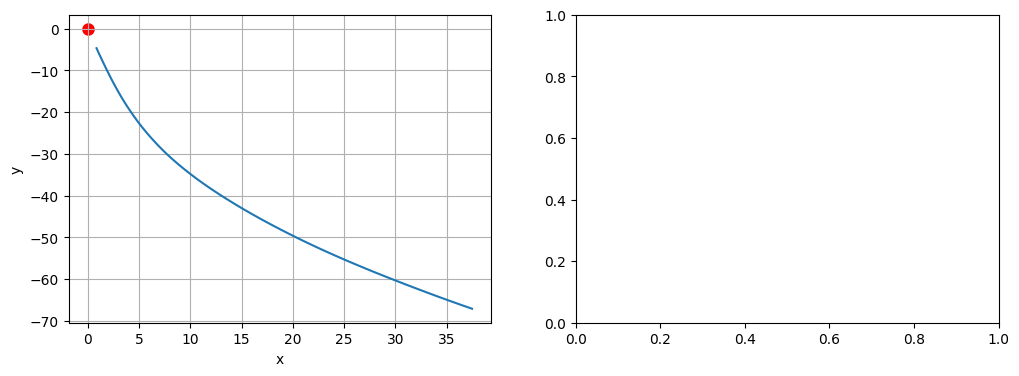

In [11]:
OBS = np.array(OBS)
print(OBS.shape)
T_end = 100
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.plot(OBS[:T_end,0], OBS[:T_end,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
# ax2.plot(OBS[:,2], OBS[:,4]); ax2.scatter(0,0, color= 'r', linewidth=3,);
# ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()

# Visualizations

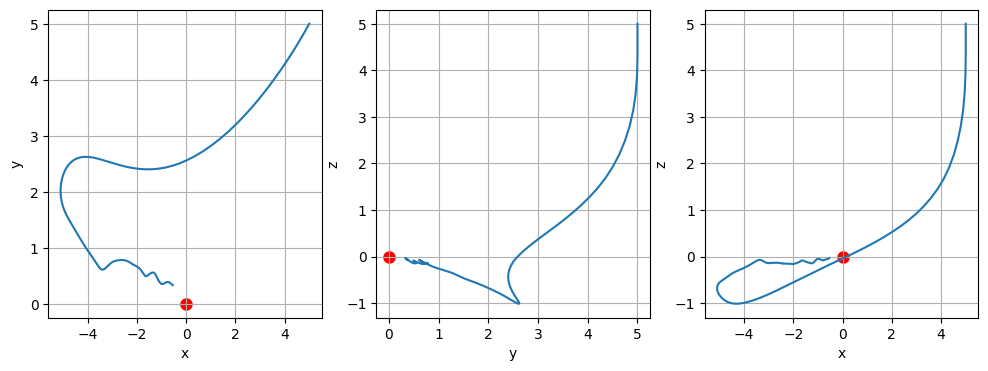

[-0.54293202  0.33101718 -0.02896317  0.11252511 -0.04216489  0.03295834
 -0.00367185  0.00484187 -0.02238284 -0.01354116  0.0180512   0.00996688]


In [41]:
import matplotlib.patches as patches

OBS = np.array(OBS)
# 3D PLOT
# ax = plt.figure().add_subplot(projection='3d') #figsize = (10,10)
# ax.plot(OBS[:,0], OBS[:,2], OBS[:,4]); ax.grid()
# ax.scatter(0,0,0,color= 'r', linewidth=3,);

# # 2D Projection 3D Plot
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
# ax1.plot(OBS[:,0], OBS[:,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
# ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
# ax2.plot(OBS[:,2], OBS[:,4]); ax2.scatter(0,0, color= 'r', linewidth=3,);
# ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
# ax3.plot(OBS[:,0], OBS[:,4]); ax3.scatter(0,0, color= 'r', linewidth=3,);
# ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()


# 2D Projection 3D Plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
ax1.plot(OBS[:,0], OBS[:,1]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
ax2.plot(OBS[:,1], OBS[:,2]); ax2.scatter(0,0, color= 'r', linewidth=3,);
ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
ax3.plot(OBS[:,0], OBS[:,2]); ax3.scatter(0,0, color= 'r', linewidth=3,);
ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()



plt.show()
# ax2.plot(OBS[:,1]); ax2.grid()
# ax3.plot(OBS[:,3]); ax3.grid()
# rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
# ax1.add_patch(rect)
print(OBS[-1])

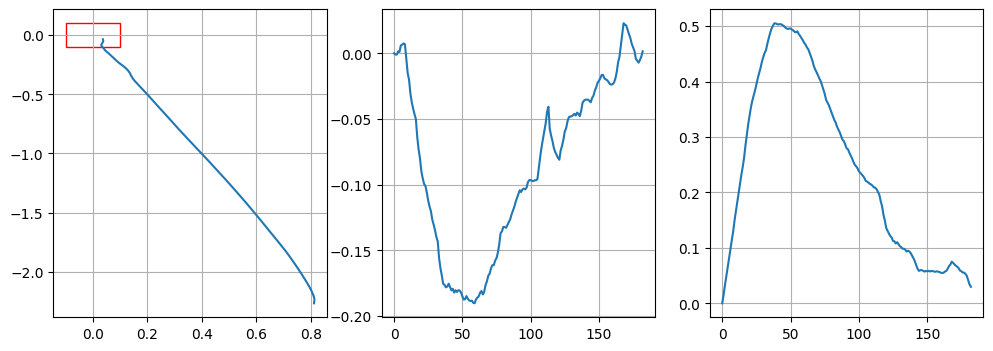

In [16]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)


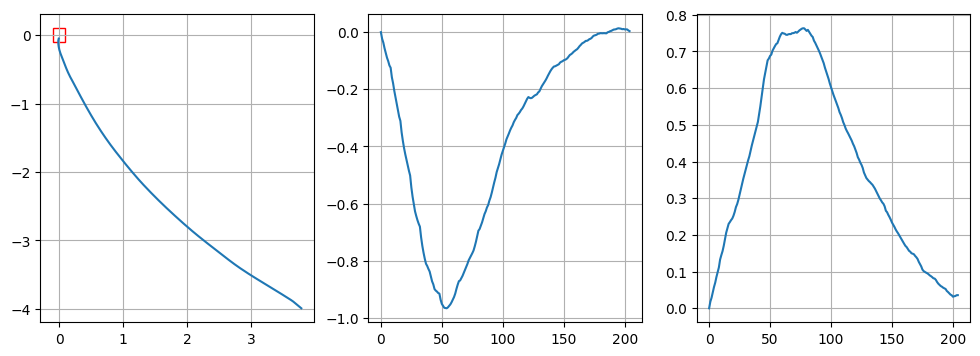

In [62]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)
